#### Import all the Dependencies

In [21]:
import tensorflow as tf
from IPython.display import HTML
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import matplotlib.pyplot as plt
%matplotlib inline

#### Set all the Constants

In [47]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

#### Data importing into tensorflow dataset object 

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato_plant",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = data.class_names
class_names

['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']

#### Now we will split the dataset in to three parts

* Training dataset: used while training
* Validation dataset: tested against while training
* Test datset: tested against after we trained a model

In [5]:
len(data)

68

20% ---> test ---> devide it in to 10% validation and 10% test # During the trainning processes after each epoch we do validation using 10% then we will do our final model then we will use the 10% dataset to measure the accuracy/performance of our model(before deploying the model).  
80% ---> trainning

In [6]:
# Let's find out how many batch sample is 80% of our dataset 
train_size = 0.8
len(data)*train_size

54.400000000000006

In [7]:
train_ds = data.take(54) # Take first 54 batch sample of the dataset to train
len(train_ds)

54

In [8]:
test_ds = data.skip(54) # skips the first 54 and show the rest of the dataset batches
len(test_ds) # the rest 14 samples are our test dataset

14

In [9]:
val_size=0.1
len(data)*val_size

6.800000000000001

In [10]:
val_ds = test_ds.take(6)
len(val_ds) # we took 6 samples as our validation dataset 

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds) # 8 batches of the dataset will be our test data

8

In [12]:
# Track the tensor flow dataset and split 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
# we will fit our dataset in to the above function and split train, test and validation 
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

#### Cache, Shuffle and Prefetch the data

In [19]:
# (AUTOTUNE) We let it(the algorithem) to choose how many baches to load inadvance.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model building

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we will resize it to the desired size. 
And, to improve the model performance, we will normalize the image pixel value (keeping them in range 0 and 1 by dividing it to 256).
This should happen while training as well as inference. Therefore we can add that as a layer in our Sequential Model.

Resizing it is useful becouse when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

#### Data Augmentation
Becouse we have a little less data, this boosts the accuracy of our model by augmenting the data. 

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4749 - loss: 0.9420 - val_accuracy: 0.4740 - val_loss: 0.8293
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5336 - loss: 0.8384 - val_accuracy: 0.7500 - val_loss: 0.6206
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7219 - loss: 0.6078 - val_accuracy: 0.8229 - val_loss: 0.3969
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8417 - loss: 0.3905 - val_accuracy: 0.8750 - val_loss: 0.3047
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8868 - loss: 0.2761 - val_accuracy: 0.9062 - val_loss: 0.2223
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9181 - loss: 0.2125 - val_accuracy: 0.8958 - val_loss: 0.2867
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9311 - loss: 0.1909 - val_accuracy: 0.8542 - val_loss: 0.5498
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9244 - loss: 0.2028 - val_accuracy: 0.8750 - v

In [32]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.9544 - loss: 0.1503


In [33]:
scores

[0.1131463348865509, 0.9609375]

#### Visualize the Accuracy and Loss Curves

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

30

In [43]:
history.history['loss'][:10] # show loss for first 10 epochs

[0.9107377529144287,
 0.8058634400367737,
 0.5282570123672485,
 0.3804348409175873,
 0.2775605618953705,
 0.2202400267124176,
 0.16719041764736176,
 0.21446944773197174,
 0.12150450795888901,
 0.09309165924787521]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

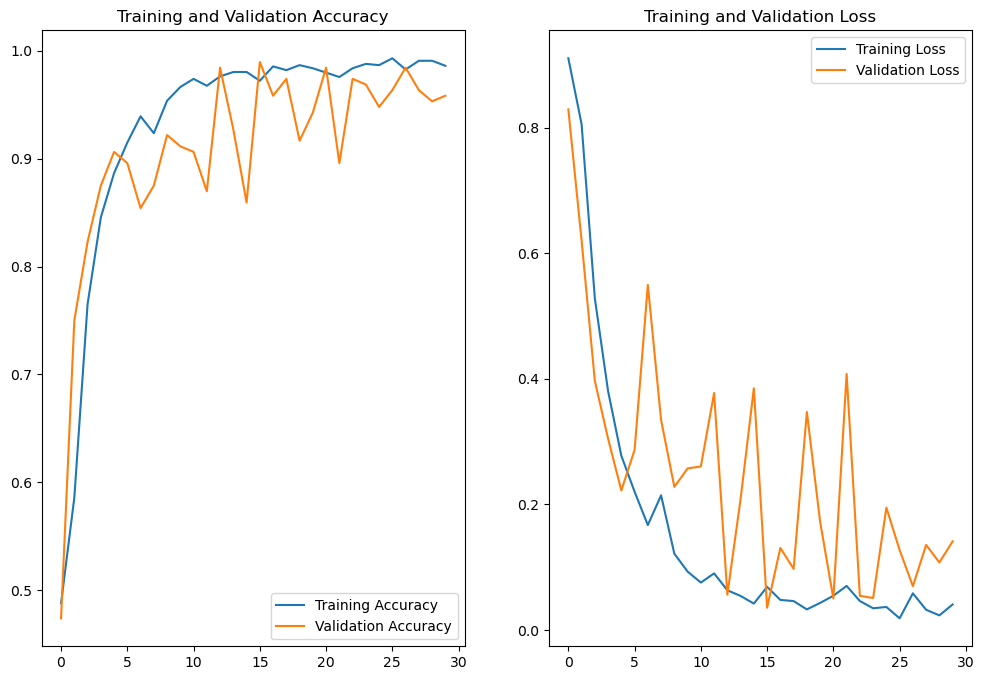

In [51]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Prediction on a sample image

actual label: Potato___Early_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
predicted label: Potato___Early_Blight


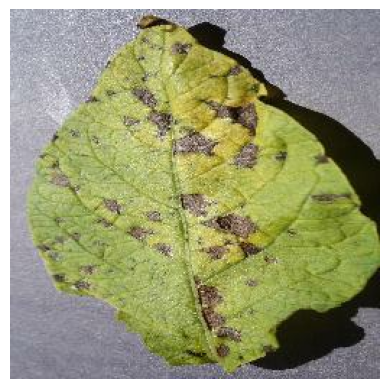

In [54]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.axis("off")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Inference

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now we will run the inference on few(12) sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


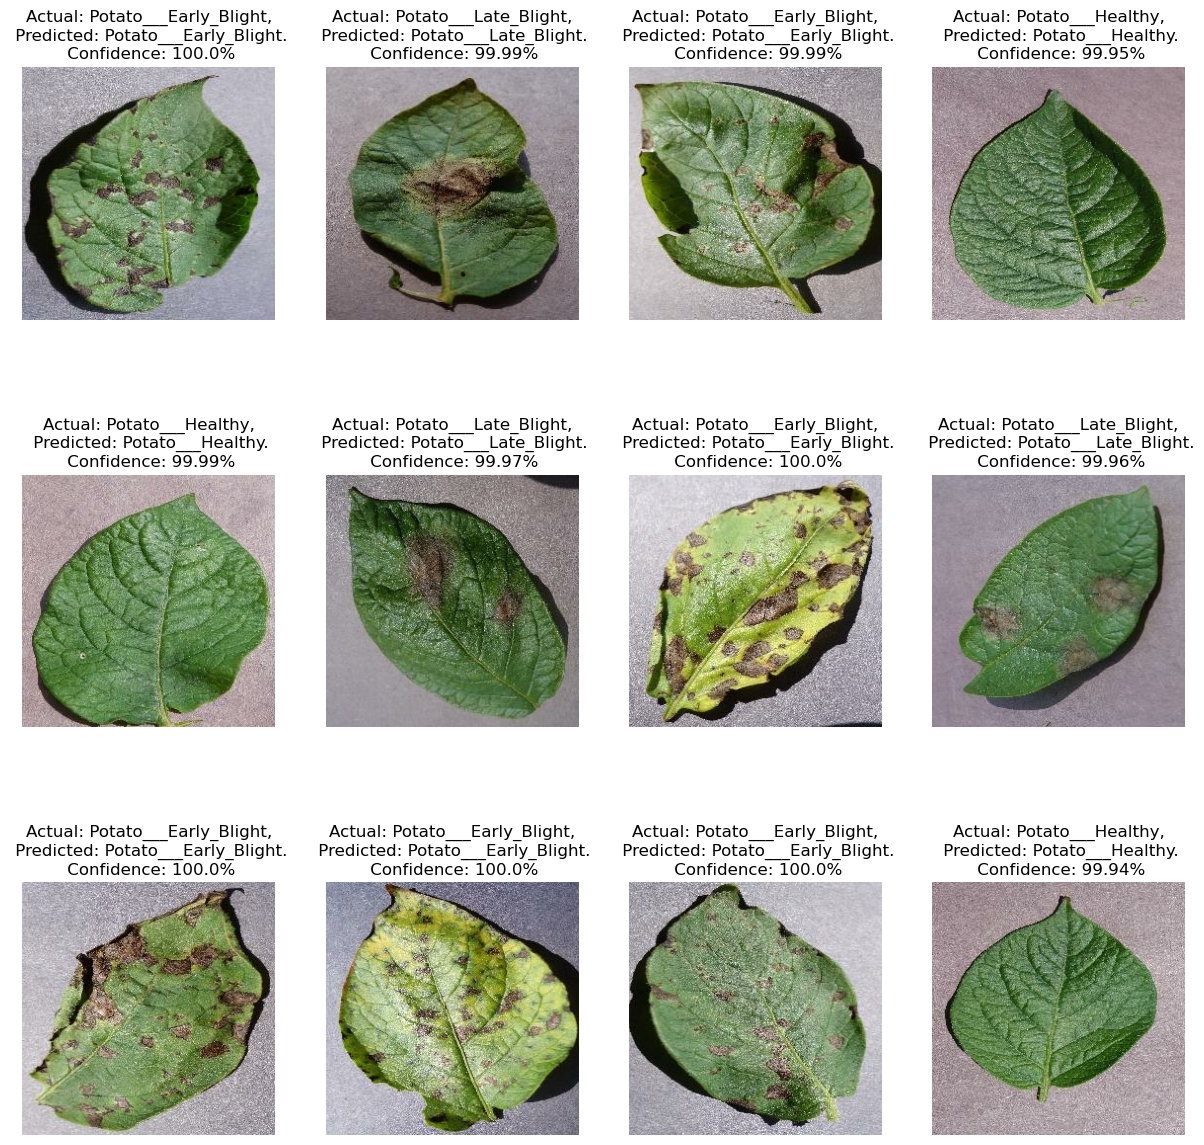

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Save the Model

In [64]:
model.save("potato_best_model.h5")